In [1]:
from gcp_fx import PROJECT_ID, pd, query_bq
import spacy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
query_bq('''select min(refresh_date),max(refresh_date), count(*) records FROM `bigquery-public-data.google_trends.top_terms`''')

shape = (1, 3)
columns =  ['f0_', 'f1_', 'records']


,f0_,f1_,records
0,2024-10-31,2024-12-01,43989750


In [2]:
NER = spacy.load("en_core_web_sm")
def get_entity(s):
    ''' for a string return an entity type

        PERSON: Refers to individuals, including fictional and real people.
        NORP: Represents nationalities, religious or political groups.
        FAC: Denotes buildings, airports, highways, bridges, etc.
        ORG: Refers to organizations such as companies, institutions, agencies, etc.
        GPE: Represents countries, cities, states, and other geopolitical entities.
        LOC: Denotes non-GPE locations such as mountains, bodies of water, etc.
        PRODUCT: Represents objects, vehicles, food items, etc.
        EVENT: Denotes named events like hurricanes, battles, wars, etc.
        WORK_OF_ART: Represents books, paintings, songs, etc.
        LAW: Denotes named laws and regulations.
        LANGUAGE: Represents named languages.
        DATE: Represents dates in various formats.
        TIME: Denotes times in various formats.
        PERCENT: Represents percentage values.
        MONEY: Denotes monetary values.
        QUANTITY: Represents measurements, quantities, or counts.
        ORDINAL: Denotes first, second, third, etc.
        CARDINAL: Represents numerical values, counting numbers.
    '''
    if NER(s).ents:
        return NER(s).ents[0].label_
    else:
        return ''

In [8]:
get_entity('John Doe')
get_entity('New York')

'PERSON'

'GPE'

In [10]:
sql = ''' select refresh_date, term, rank as search_rank
FROM `bigquery-public-data.google_trends.top_terms`
WHERE rank<=5
group by 1,2,3
order by 1 desc, 3
'''

df = query_bq(sql).assign(ent=lambda x: [get_entity(s) for s in x.term])
df.head(10)


shape = (160, 3)
columns =  ['refresh_date', 'term', 'search_rank']


,refresh_date,term,search_rank,ent
0,2024-12-01,Michigan vs Ohio State,1,GPE
1,2024-12-01,Kash Patel,2,PERSON
2,2024-12-01,South Carolina football,3,GPE
3,2024-12-01,Miami Football,4,GPE
4,2024-12-01,Buffalo Bills,5,
5,2024-11-30,Georgia football,1,GPE
6,2024-11-30,Josh Allen,2,PERSON
7,2024-11-30,Colorado football,3,GPE
8,2024-11-30,College Football,4,
9,2024-11-30,Clemson football,5,


In [11]:
def add_ttl(_df):
    return (
        df
        .assign(ttl=lambda x: x.groupby('ent').transform('size'))
        .sort_values('ttl',ascending=False)
    )
df.pipe(add_ttl)  
# perhaps a newer downlaod of the web corpus would have less blanks. or maybe the larger model

,refresh_date,term,search_rank,ent,ttl
80,2024-11-15,Eagles,1,,47
67,2024-11-18,Bills,3,,47
36,2024-11-24,Auburn football,2,,47
136,2024-11-04,Where to vote,2,,47
38,2024-11-24,Ole Miss football,4,,47
...,...,...,...,...,...
115,2024-11-08,Bengals vs Ravens,1,PRODUCT,1
68,2024-11-18,Seahawks vs 49ers,4,CARDINAL,1
156,2024-10-31,World Series Game 5,2,EVENT,1
111,2024-11-09,Grammy nominations 2025,2,WORK_OF_ART,1


               47
PERSON         45
GPE            26
ORG            26
DATE            8
NORP            3
CARDINAL        1
FAC             1
WORK_OF_ART     1
PRODUCT         1
EVENT           1
Name: ent, dtype: int64


<Axes: >

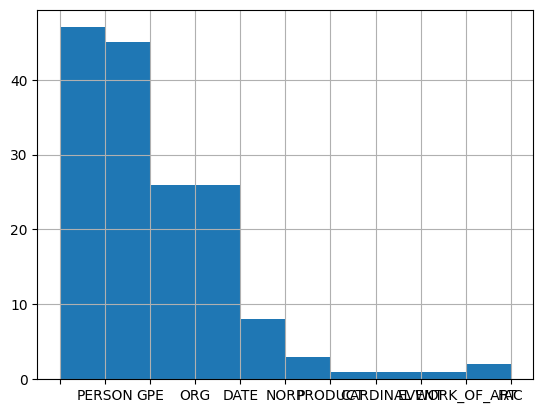

In [12]:
print(df.ent.value_counts())
df.pipe(add_ttl).ent.hist()

#### conclusion: 
we tend to google people, then places, then orgs.